In [1]:
import h5py
import numpy as np
import scipy.io
from keras.utils.io_utils import HDF5Matrix
import matplotlib.pyplot as plt

E:\program\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Instantiating HDF5Matrix for the training set, which is a slice of the first 150 elements
X_train = HDF5Matrix('resized.mat', 'images', start=0, end=100)
y_train = HDF5Matrix('resized.mat', 'labels', start=0, end=100)

y_train = np.expand_dims(np.asarray(y_train), axis = 3)

# Likewise for the test set
X_test = HDF5Matrix('resized.mat', 'images', start=100, end=110)
y_test = HDF5Matrix('resized.mat', 'labels', start=100, end=110)
#X_test = X_test.resize([X_test.shape[0],224,224,3])

y_test = np.expand_dims(np.asarray(y_test), axis = 3)
print(y_train.shape)
print(X_train.shape)

(100, 320, 240, 1)
(100, 320, 240, 3)


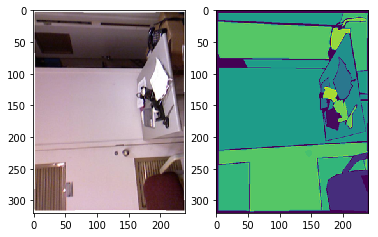

In [3]:
plt.figure(1)
plt.subplot(121)
plt.imshow(X_train[2])

plt.subplot(122)
plt.imshow(y_train[2][:,:,0])
plt.show()

In [4]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from PIL import Image
import keras
import tensorflow as tf

In [5]:
# create the base pre-trained model
# inceptionV3 default input 299*299
base_model = InceptionV3(weights='imagenet', include_top=False)
#base_model = ResNet50(weights='imagenet')

In [7]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [19]:
def upsample_incp(x):
    x = keras.layers.Conv2DTranspose(filters = 1024, kernel_size= 7, padding = 'valid',
                                     strides= 2 , activation = 'relu')(x)
    #x = keras.layers.Conv2DTranspose(filters = 512, kernel_size= 5, padding = 'same',
    #                                strides= 2 , activation = 'relu')(x)
    #x = keras.layers.Conv2DTranspose(filters = 256, kernel_size= 3, padding = 'same',
    #                                 strides= 2 , activation = 'relu')(x)
    #x = keras.layers.Conv2DTranspose(filters = 128, kernel_size= 3, padding = 'same',
    #                                 strides= 2 , activation = 'relu')(x)
    #x = keras.layers.Conv2DTranspose(filters = 64, kernel_size= 3, padding = 'same',
    #                                 strides= 2 , activation = 'relu')(x)
    return x

In [7]:
def huber_loss(y_true, y_pred, clip_delta=1.0):
    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
    return tf.keras.backend.mean(tf.where(cond, squared_loss, linear_loss))

In [47]:
x = base_model.get_layer('conv2d_1').output
x

<tf.Tensor 'conv2d_1/convolution:0' shape=(?, ?, ?, 32) dtype=float32>

In [48]:
# add a global spatial average pooling layer
dropout_rate = 0.5

# 8*6*1280
x = base_model.get_layer('mixed8').output

# conv2d_trans: 18*14
x = keras.layers.Conv2DTranspose(filters = 768, kernel_size= 4, padding = 'valid',
                               strides= 2 , activation = 'relu')(x)
x =  keras.layers.Cropping2D(cropping=((0, 0), (0, 1)))(x)
# 'mixed5': 18*13*768   
mixed5 = base_model.get_layer('mixed5').output
#mixed5 = keras.layers.Cropping2D(cropping=((0, 1), (0, 0)))(mixed5)
x = keras.layers.Add()([x, mixed5])
# out : 18*13*768

# conv2d_trans: 37*27
x = keras.layers.Conv2DTranspose(filters = 288, kernel_size= 3, padding = 'valid',
                                strides= 2 , activation = 'relu')(x)
# 'mixed5': 37*27*288
mixed2 = base_model.get_layer('mixed2').output
#mixed2 = keras.layers.Cropping2D(cropping=((1, 1), (0, 0)))(mixed2)
x = keras.layers.Add()([x, mixed2])
# out : 37*27*288


# 77*57*...
x = keras.layers.Conv2DTranspose(filters = 80, kernel_size= 5, padding = 'valid',
                                 strides= 2 , activation = 'relu')(x)
# 78*58*.
mixed0 = base_model.get_layer('conv2d_4').output
mixed0 = keras.layers.Cropping2D(cropping=((1, 0), (1, 0)))(mixed0)
x = keras.layers.Add()([x, mixed0])
#out : 77*57*80

x = keras.layers.Conv2DTranspose(filters = 64, kernel_size= 5, padding = 'valid',
                                 strides= 2 , activation = 'relu')(x)
#out : 157*117*64

x = keras.layers.Conv2DTranspose(filters = 32, kernel_size= 3, padding = 'valid',
                                 strides= 1 , activation = 'relu')(x)
#out : 159*119*32

x = keras.layers.Conv2DTranspose(filters = 32, kernel_size= 4, padding = 'valid',
                                 strides= 2 , activation = 'relu')(x)
#out : 320*240*32

x = keras.layers.Dropout(rate = dropout_rate)(x)

predictions = keras.layers.Conv2D(filters = 1,  kernel_size= 3, padding = 'same',
                                     strides= 1 , activation = 'relu')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss=huber_loss)

In [49]:
batchsize = 32
epoch = 10

# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     vertical_flip=True
                     #,zca_whitening=True
                    )

image_datagen = image.ImageDataGenerator(**data_gen_args)
mask_datagen = image.ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(X_train,y_train, batch_size=batchsize, seed=seed)

#mask_generator = image_datagen.flow(y_train,batch_size=batchsize, seed=seed)

# combine generators into one which yields image and masks
#train_generator = zip(image_generator, mask_generator)

In [ ]:
model.fit_generator(image_generator,
                    steps_per_epoch=10, epochs=2)

Epoch 1/2


In [1]:
# evaluate the model
scores = model.evaluate(X, Y, verbose=0)

NameError: name 'model' is not defined

## save model as json

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

## save model as image

In [41]:
# get the model as figure
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils import plot_model
plot_model(model, to_file='modelres.png')

## save model to yaml

In [ ]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load YAML and create model
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))